# High Value Customers Identification

## 0. Importação de Bibliotecas e *Helper Functions*

In [140]:
import re
import warnings
import numpy      as np
import pandas     as pd
import seaborn    as sns
import umap.umap_ as umap
from plotly              import express as px
from matplotlib          import pyplot as plt
from sklearn.cluster     import KMeans
from sklearn.metrics     import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.preprocessing import StandardScaler

In [2]:
def personal_settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['font.size'] = 20
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.float_format', lambda x:'%.2f' % x)
    sns.set()
    sns.set(rc = {'figure.figsize':(12,6)})
    warnings.filterwarnings('ignore')

personal_settings()

## 1. Carregando os Dados

In [69]:
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='unicode_escape')
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.00,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.00,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.00,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.00,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.00,United Kingdom,NaN


In [70]:
df_raw = df_raw.drop(columns='Unnamed: 8')
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.00,United Kingdom


## 2. Descrição dos Dados

In [71]:
df1 = df_raw.copy()

### 2.1 Renomeando Colunas

In [72]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [73]:
new_cols = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = new_cols
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

### 2.2 Dicionário de Colunas

|     Coluna    |              Significado              |
| ------------- | ------------------------------------- |
|   invoice_no   | identificador único de cada transação   |
|   stock_code   | código do item                        |
|   description | nome do item                          |
|   quantity    | quantidade de cada item por transação |
|   invoice_date | data da transação                     |
|   unit_price   | preço do item por unidade             |
|   customer_id  | identificador único do cliente        |
|   country     | país em que o cliente reside          |

### 2.3 Dimensões

In [74]:
print(f'Número de linhas/registros: {df1.shape[0]}')
print(f'Número de colunas/atributos: {df1.shape[1]}')

Número de linhas/registros: 541909
Número de colunas/atributos: 8


### 2.4 Tipos de Dados

In [75]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

### 2.5 Registros Duplicados

In [76]:
df1.duplicated().sum()

5269

### 2.6 Valores Nulos

In [77]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 2.7 Removendo Valores Nulos

In [78]:
df1 = df1.dropna(subset=['description', 'customer_id'])
print('Porcentagem de dados removidos: {:.2f}%'.format((1-(df1.shape[0] / df_raw.shape[0])) * 100))
print(f'Número de registros restantes: {df1.shape[0]}')

Porcentagem de dados removidos: 24.93%
Número de registros restantes: 406829


In [79]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

### 2.8 Alterando Tipos de Dados

#### 2.8.1 *InvoiceDate*

In [80]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')
df1['invoice_date'].head()

0   2016-11-29
1   2016-11-29
2   2016-11-29
3   2016-11-29
4   2016-11-29
Name: invoice_date, dtype: datetime64[ns]

#### 2.8.2 *CustomerID*

In [81]:
df1['customer_id'] = df1['customer_id'].astype('int64')
df1['customer_id'].head()

0    17850
1    17850
2    17850
3    17850
4    17850
Name: customer_id, dtype: int64

### 2.9 Análise Estatística Descritiva

#### 2.9.1 Atributos Numéricos

In [86]:
df1_numerical = df1.select_dtypes(include=['int64', 'float64'])
df1_numerical = df1_numerical.drop(columns='customer_id')
df1_numerical.head()

,quantity,unit_price
0,6,2.55
1,6,3.39
2,8,2.75
3,6,3.39
4,6,3.39


In [87]:
df_mean     = pd.DataFrame(df1_numerical.apply(np.mean)).T
df_median   = pd.DataFrame(df1_numerical.apply(np.median)).T
df_std      = pd.DataFrame(df1_numerical.apply(np.std)).T
df_min      = pd.DataFrame(df1_numerical.apply(min)).T
df_max      = pd.DataFrame(df1_numerical.apply(max)).T
df_range    = pd.DataFrame(df1_numerical.apply(lambda x: x.max() - x.min())).T
df_skew     = pd.DataFrame(df1_numerical.apply(lambda x: x.skew())).T
df_kurtosis = pd.DataFrame(df1_numerical.apply(lambda x: x.kurtosis())).T

In [88]:
df_desc = pd.concat([df_min, df_max, df_range, df_mean, df_median, df_std, df_skew, df_kurtosis]).T.reset_index()
df_desc.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
df_desc

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.00,161990.00,12.06,5.00,248.69,0.18,94317.56
1,unit_price,0.00,38970.00,38970.00,3.46,1.95,69.32,452.22,246924.54


Nessa pequena tabela já podemos verificar que: 
- Aparentemente temos quantidade de produtos negativa (o que pode representar um cancelamento de venda ou troca/devolução de um produto comprado); 
- Além disso, temos um número grande (80995) como quantidade máxima de produtos vendidos, o que pode representar um erro de digitação ou um *outlier*; 
- Falando de preço, temos um produto com preço 0, o que pode representar um erro de digitação ou alguma promoção ou brinde concedido para um cliente; 

#### 2.9.2 Atributos Categóricos

In [90]:
df1_cat = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])
df1_cat.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


##### *invoice_no*

Aparentemente, a variável *invoice_no* apresenta somente números, mas se tentamos converter o tipo de dado de *object* para *int*, não é possível, indicando que existe algum registro que contem um *char* além de número inteiros.

Assim, vou utilizar de REGEX para verificar quantos registros existem contendo um *char* além dos números.

In [97]:
len(df1_cat.loc[df1_cat['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'invoice_no'].drop_duplicates())

3654

##### *stock_code*

Aqui temos a mesma situação da variável anterior, não é possível converter de *object* para *int* por causa da presença de letras junto com números, bem como de registros compostos puramente por letras. 

Assim, vou utilizar novamente de REGEX para verificar quais são os códigos compostos puramente por letras.

In [99]:
df1_cat.loc[df1_cat['stock_code'].apply(lambda x: bool(re.search('^[a-zA-z]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

## 3. Filtragem de Variáveis

Como temos algumas variáveis com 'sujeira', vou filtrar os dados primeiro para depois criar novas variáveis para auxiliar na clusterização dos clientes.

In [100]:
df2 = df1.copy()

In [102]:
df2.sample(1)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
99773,544788,16161P,WRAP ENGLISH ROSE,25,2017-02-21,0.42,13089,United Kingdom


### 3.1 *quantity*

Para essa variável, já vimos que existem valores negativos, então vou assumir que esses valores representam uma devolução de produto por parte do cliente. 

O número de devoluções deve ser levado em conta no momento da clusterização e da possível participação do cliente no novo programa de fidelização da empresa.

Assim, vou criar dois conjunto de dados separados - um com quantidade de produtos acima de 0 e outro abaixo de 0.

In [120]:
df_returns = df2.loc[df2['quantity'] < 0, :]
df_purchases = df2.loc[df2['quantity'] > 0, :]

### 3.2 *unit_price*

Como também já visto acima, existem transações com preços por unidade negativos, assim filtrar o conjunto de dados original para que contenha apenas transações com preços por unidade positivos, para não afetar o cálculo do faturamento bruto por cliente na etapa posterior.

In [104]:
df2 = df2.loc[df2['unit_price'] > 0.010, :]

### 3.3 *stock_code*

Aqui também já vimos que existem código de produtos composto exclusivamente por letras, de forma que vou retirar esses registros do conjunto de dados.

In [105]:
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'])]

## 4. *Feature Engineering* - Criação de Variáveis

In [121]:
df3 = df2.copy()

### 4.1 Criação de features com base no RFM Model (Recency, Frequency e Monetary)

In [122]:
df3.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

In [123]:
df_ref = df3.drop(columns=['invoice_no', 'stock_code', 'description', 'quantity', 
                           'invoice_date', 'unit_price', 'country']).drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


#### 4.1.1 Gross Revenue (Monetary)

Para a métrica monetária, vou adotar o faturamento bruto por cliente, calculado com base somente nas compras feitas.

In [124]:
df_purchases['gross_revenue'] = df_purchases['quantity'] * df_purchases['unit_price']

In [125]:
df_monetary = df_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_monetary.head()

,customer_id,gross_revenue
0,12346,77183.60
1,12347,4310.00
2,12348,1437.24
3,12349,1457.55
4,12350,294.40


In [126]:
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
df_ref.head()

,customer_id,gross_revenue
0,17850,5391.21
1,13047,3232.59
2,12583,6705.38
3,13748,948.25
4,15100,876.00


In [127]:
df_ref.isna().sum()

customer_id       0
gross_revenue    27
dtype: int64

#### 4.1.2 Recency

Número de dias desde a última compra feita pelo cliente.

Como último dia para comparação, vou pegar a data da última transação no conjunto de dados que contém somente compras, vez que não me interessa quando o cliente devolveu um produto pela última vez.

In [128]:
# Obtendo a data de transação mais recente por cliente
df_recency = df_purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency.head()

,customer_id,invoice_date
0,12346,2017-01-16
1,12347,2017-12-05
2,12348,2017-09-23
3,12349,2017-11-19
4,12350,2017-01-31


In [129]:
# Calculando o número de dias desde a última transação
df_recency['recency'] = (df_purchases['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency.drop(columns=['invoice_date'])
df_recency.head()

,customer_id,recency
0,12346,325
1,12347,2
2,12348,75
3,12349,18
4,12350,310


In [130]:
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.head()

,customer_id,gross_revenue,recency
0,17850,5391.21,372.00
1,13047,3232.59,56.00
2,12583,6705.38,2.00
3,13748,948.25,95.00
4,15100,876.00,333.00


In [131]:
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency          27
dtype: int64

#### 4.1.3 Frequency

A frequência corresponde a quantas vezes o cliente comprou algum produto. 

Da mesma forma que na recência, o que me interessa aqui é quantas vezes o cliente comprou um produto, e não devolveu.

In [132]:
df_frequency = df_purchases[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns= {'invoice_no': 'frequency'})
df_frequency.head()

,customer_id,frequency
0,12346,1
1,12347,7
2,12348,4
3,12349,1
4,12350,1


In [133]:
df_ref = pd.merge(df_ref, df_frequency, on='customer_id', how='left')
df_ref.head()

,customer_id,gross_revenue,recency,frequency
0,17850,5391.21,372.00,34.00
1,13047,3232.59,56.00,9.00
2,12583,6705.38,2.00,15.00
3,13748,948.25,95.00,5.00
4,15100,876.00,333.00,3.00


In [134]:
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency          27
frequency        27
dtype: int64

#### 4.1.4 Average Ticket

O ticket médio corresponde quanto, na média, cada cliente gasta por compra. 

Aqui também o que me interessa são as compras feitas por cada cliente, e não as devoluções.

In [135]:
df_avg_ticket = df_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_avg_ticket.head()

,customer_id,avg_ticket
0,12346,77183.60
1,12347,23.68
2,12348,53.23
3,12349,20.24
4,12350,18.40


In [136]:
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.head()

,customer_id,gross_revenue,recency,frequency,avg_ticket
0,17850,5391.21,372.00,34.00,18.15
1,13047,3232.59,56.00,9.00,18.90
2,12583,6705.38,2.00,15.00,28.90
3,13748,948.25,95.00,5.00,33.87
4,15100,876.00,333.00,3.00,292.00


In [145]:
df_ref.isna().sum()

customer_id         0
gross_revenue      27
recency            27
frequency          27
avg_ticket         27
returns          2828
dtype: int64

#### 4.1.5 Returns

In [143]:
df_n_returns = df_returns[['customer_id', 'invoice_no']].groupby('customer_id').count().reset_index().drop_duplicates().rename(columns={'invoice_no': 'returns'})
df_n_returns.head()

,customer_id,returns
0,12346,1
1,12352,7
2,12359,6
3,12362,8
4,12375,1


In [144]:
df_ref = pd.merge(df_ref, df_n_returns, on='customer_id', how='left')
df_ref.head()

,customer_id,gross_revenue,recency,frequency,avg_ticket,returns
0,17850,5391.21,372.00,34.00,18.15,15.00
1,13047,3232.59,56.00,9.00,18.90,23.00
2,12583,6705.38,2.00,15.00,28.90,3.00
3,13748,948.25,95.00,5.00,33.87,NaN
4,15100,876.00,333.00,3.00,292.00,3.00


In [146]:
df_ref.isna().sum()

customer_id         0
gross_revenue      27
recency            27
frequency          27
avg_ticket         27
returns          2828
dtype: int64

## 5. Análise Exploratória de Dados

In [147]:
df4 = df_ref.dropna().copy()

## 6. Preparação dos Dados

In [148]:
df5 = df4.copy()

In [149]:
ss = StandardScaler()

In [151]:
df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']])
df5['recency'] = ss.fit_transform(df5[['recency']])
df5['frequency'] = ss.fit_transform(df5[['frequency']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])
df5['returns'] = ss.fit_transform(df5[['returns']])

In [152]:
df5.sample()

,customer_id,gross_revenue,recency,frequency,avg_ticket,returns
3755,15473,-0.17,-0.60,-0.04,0.01,-0.23


## 7. *Feature Selection* - Seleção de Variáveis

In [153]:
df6 = df5.copy()

## 8. *Hyperparemeter Fine Tunning* - Encontrando o Melhor Número de Clusters

Para encontrar o melhor valor de clusters, vou usar do algoritmo *KMeans*, e comparar a performance de acordo com métricas de *Compactness* e *Separation*.

In [154]:
X = df6.drop(columns=['customer_id'])
X.head()

,gross_revenue,recency,frequency,avg_ticket,returns
0,0.10,3.62,2.26,-0.05,0.83
1,-0.06,-0.11,0.13,-0.05,1.53
2,0.20,-0.74,0.64,-0.04,-0.23
4,-0.24,3.16,-0.38,0.06,-0.23
5,0.04,-0.47,0.56,-0.04,0.03


In [155]:
n_clusters = [2, 3, 4, 5, 6, 7]

### 8.1 WCSS (*Within-Cluster Sum of Square*)

A métrica usada para verificar a *Compactness* dos clusters vai ser o WCSS (*Within-Cluster Sum of Square*) 

Para verificar essa métrica para diferentes números de clusters, vou usar do método do Cotovelo (*Elbow Method*).

De acordo com esse método, o melhor valor de clusters vai ser aquele que apresenta a maior diferença/variação em comparação com o próximo valor (o cotovelo no gráfico).

Para facilitar, a função *KElbowVisualizer* já indica qual o melhor valor para o número de clusters no gráfico.

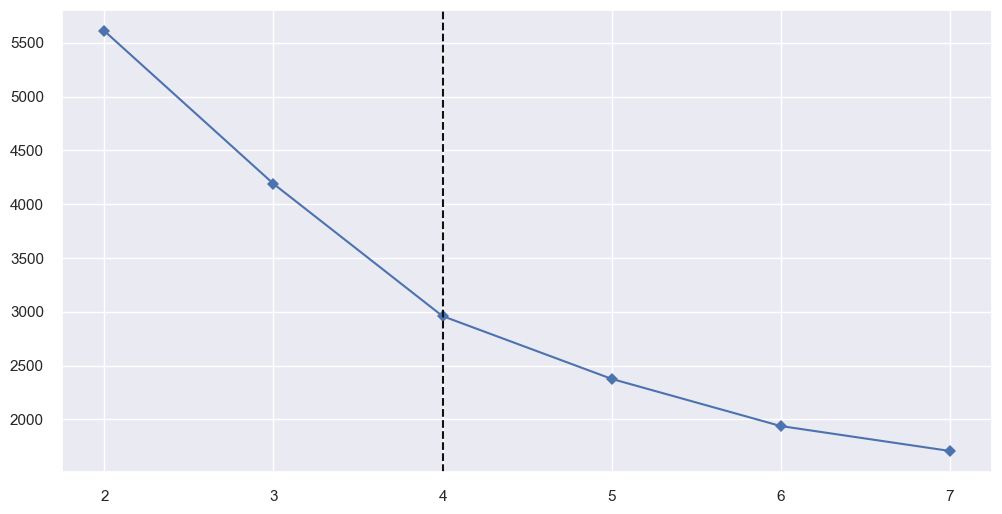

In [156]:
kmeans = KElbowVisualizer(KMeans(), k=n_clusters, timings=False)
kmeans.fit(X)
kmeans.show;

De acordo com a WCSS, o melhor número de clusters é 4. 

### 8.2 SS (*Silhouette Score*)

A métrica usada para verificar a *Separation* dos clusters vai ser a *Silhouette Score*

Para verificar essa métrica para diferentes números de clusters, também vou usar da função *KElbowVisualizer*, mas passando como parâmetro a métrica *silhouette*.

De acordo com essa métrica, o melhor valor para o número de clusters vai ser aquele que apresentar uma *Silhouette Score* mais próxima de 1. 

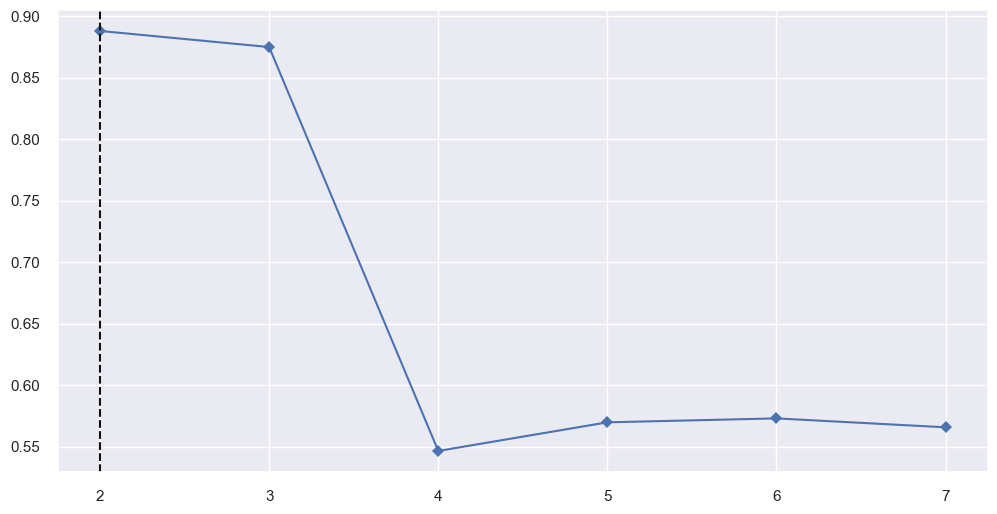

In [157]:
kmeans = KElbowVisualizer(KMeans(), k=n_clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show;

De acordo com a SS, o melhor número de clusters é 2, mas podemos ver que 3 clusters não apresentam uma performance muito pior. 

Assim, vou seguir com 3 clusters para o conjunto de dados.

### 8.3 *Silhouette Analysis*

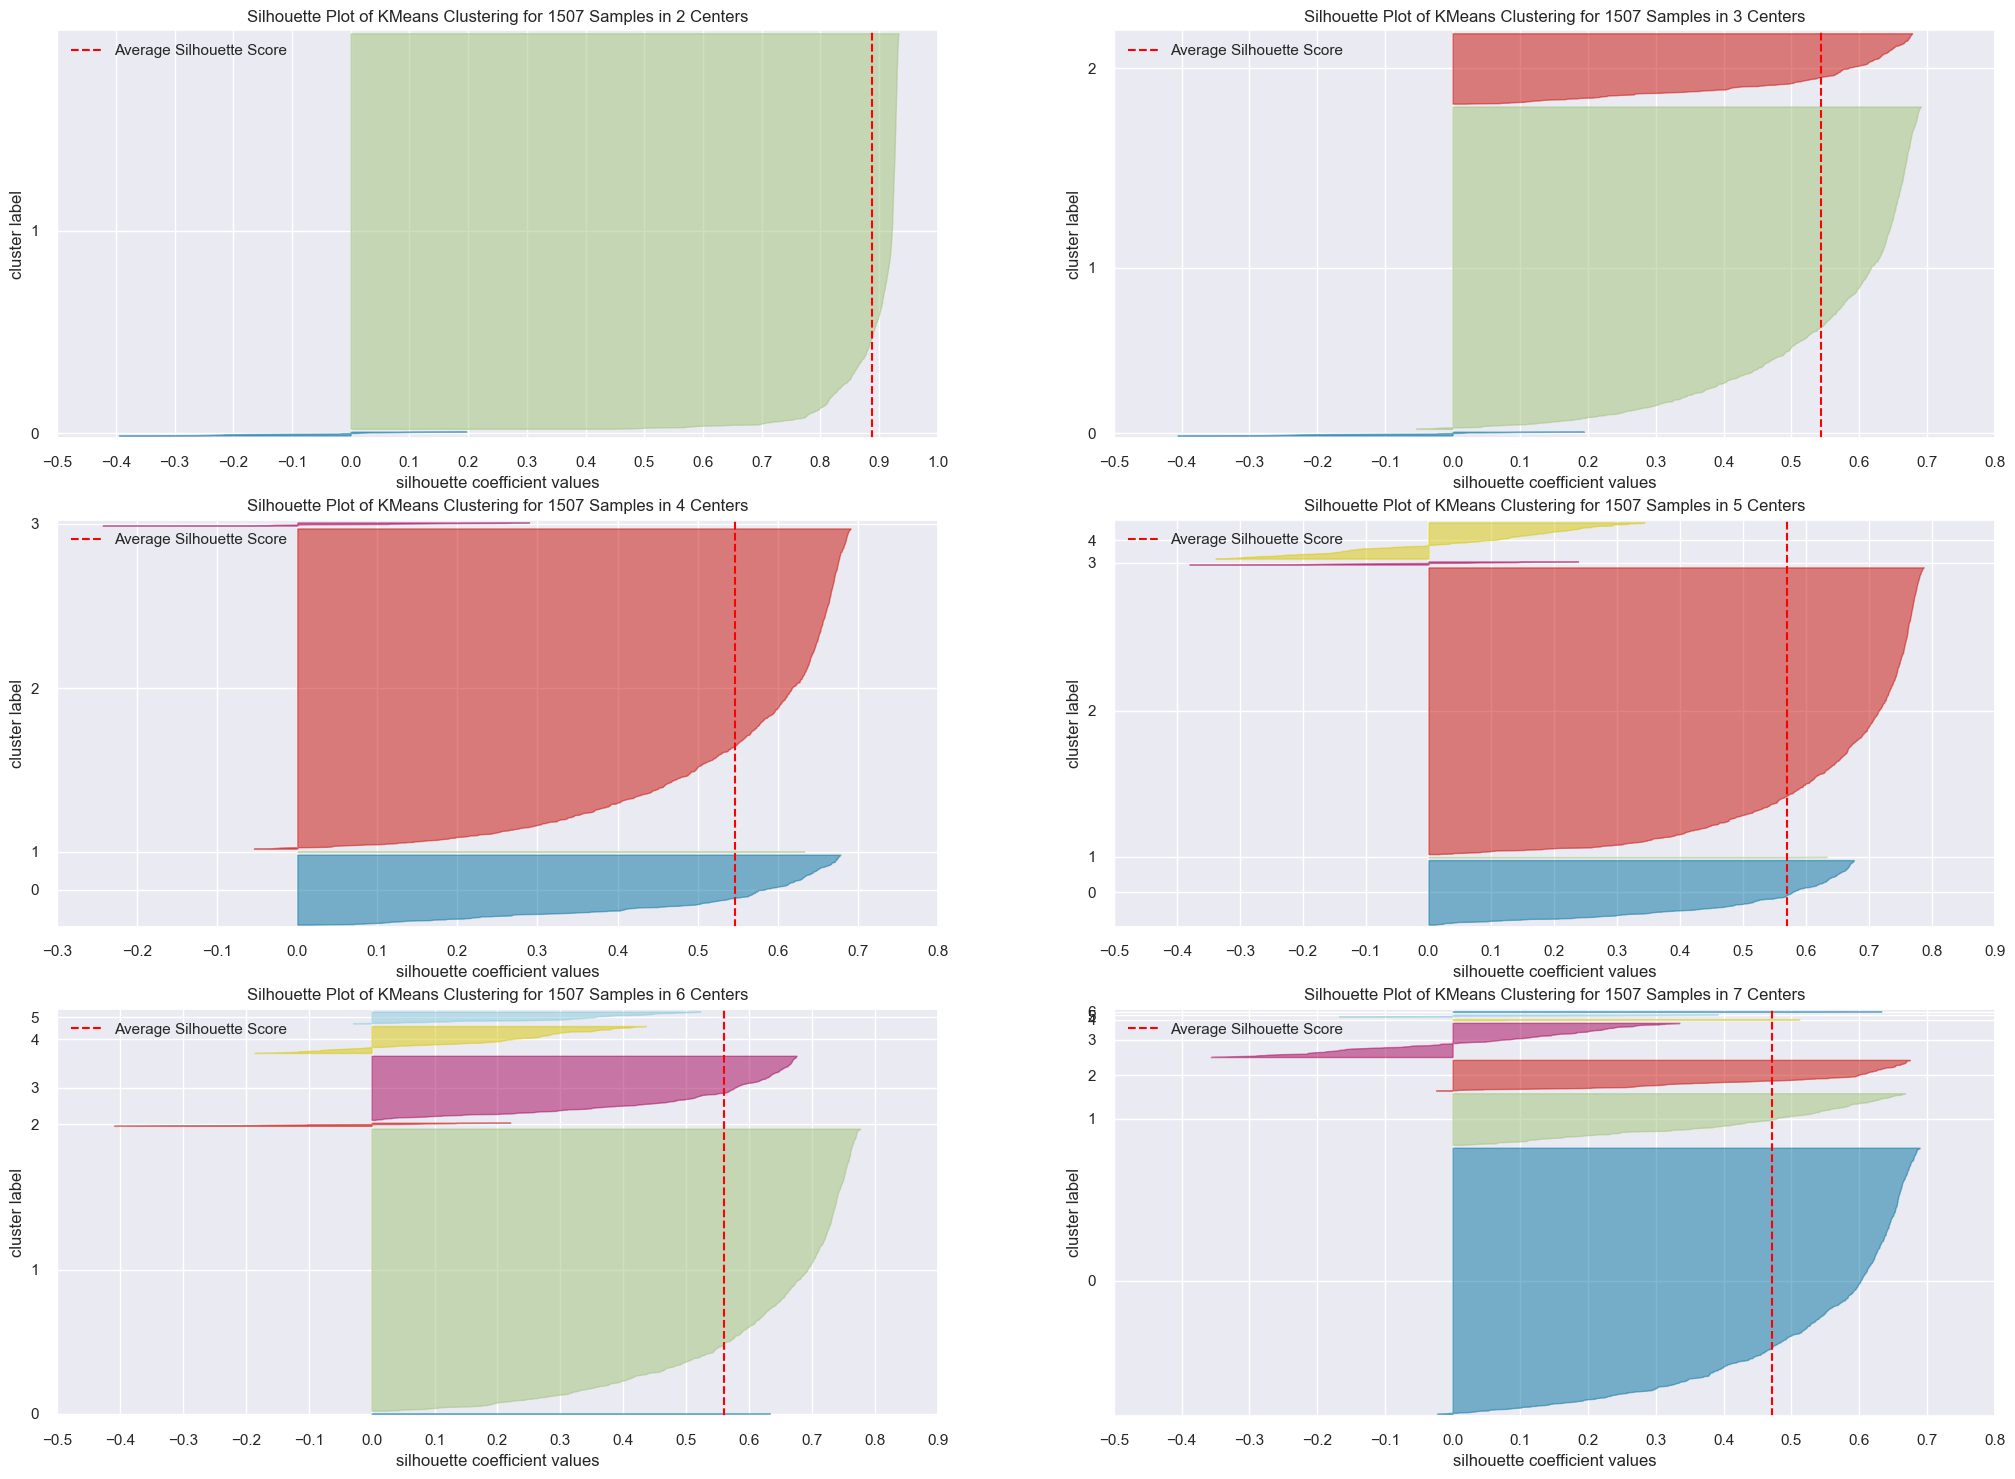

In [158]:
fig, ax = plt.subplots(3, 2, figsize=(25, 18))

for k in n_clusters:
  km = KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
  q, mod = divmod(k, 2)
  visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
  visualizer.fit(X)
  visualizer.finalize()

## 9. *Machine Learning*

### 9.1 *KMeans*

In [159]:
# Modelo
k = 3
kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# Treinamento
kmeans.fit(X)

# Clustering
labels = kmeans.labels_

#### 9.1.2 *Cluster Validation*

In [160]:
# WSS
print('WSS: {:.2f}'.format(kmeans.inertia_))
# SS
print('SS: {:.2f}'.format(silhouette_score(X, labels, metric='euclidean')))

WSS: 4381.28
SS: 0.54


## 10. *Cluster Analysis*

In [175]:
df4.head()

,customer_id,gross_revenue,recency,frequency,avg_ticket,returns
0,17850,5391.21,372.00,34.00,18.15,15.00
1,13047,3232.59,56.00,9.00,18.90,23.00
2,12583,6705.38,2.00,15.00,28.90,3.00
4,15100,876.00,333.00,3.00,292.00,3.00
5,15291,4623.30,25.00,14.00,45.33,6.00


In [176]:
#df7 = df6.copy()
df7 = df4.copy()
df7['cluster'] = labels
df7.head()

,customer_id,gross_revenue,recency,frequency,avg_ticket,returns,cluster
0,17850,5391.21,372.00,34.00,18.15,15.00,2
1,13047,3232.59,56.00,9.00,18.90,23.00,1
2,12583,6705.38,2.00,15.00,28.90,3.00,1
4,15100,876.00,333.00,3.00,292.00,3.00,2
5,15291,4623.30,25.00,14.00,45.33,6.00,1


### 10.1 *Visual Inspection*

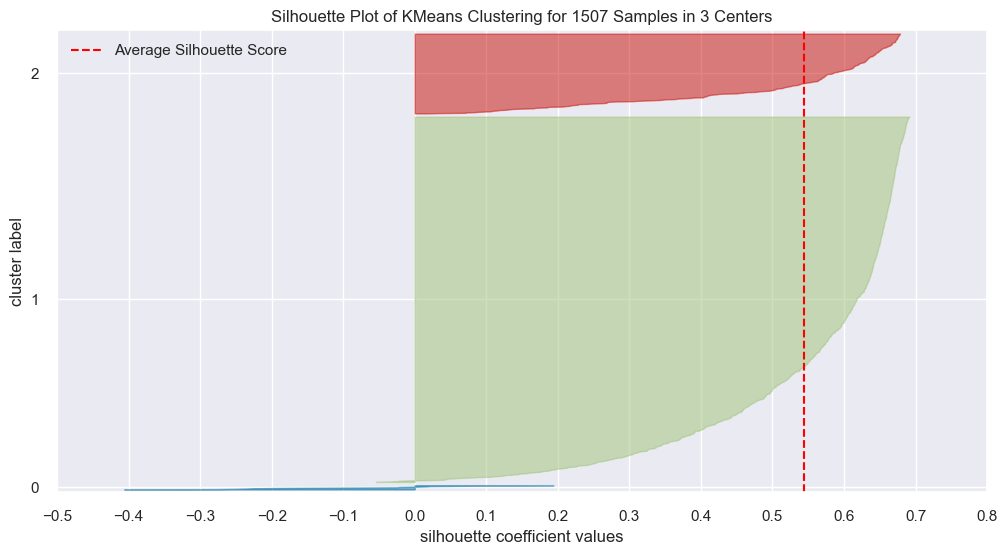

In [162]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

### 10.2 *2D Plot*

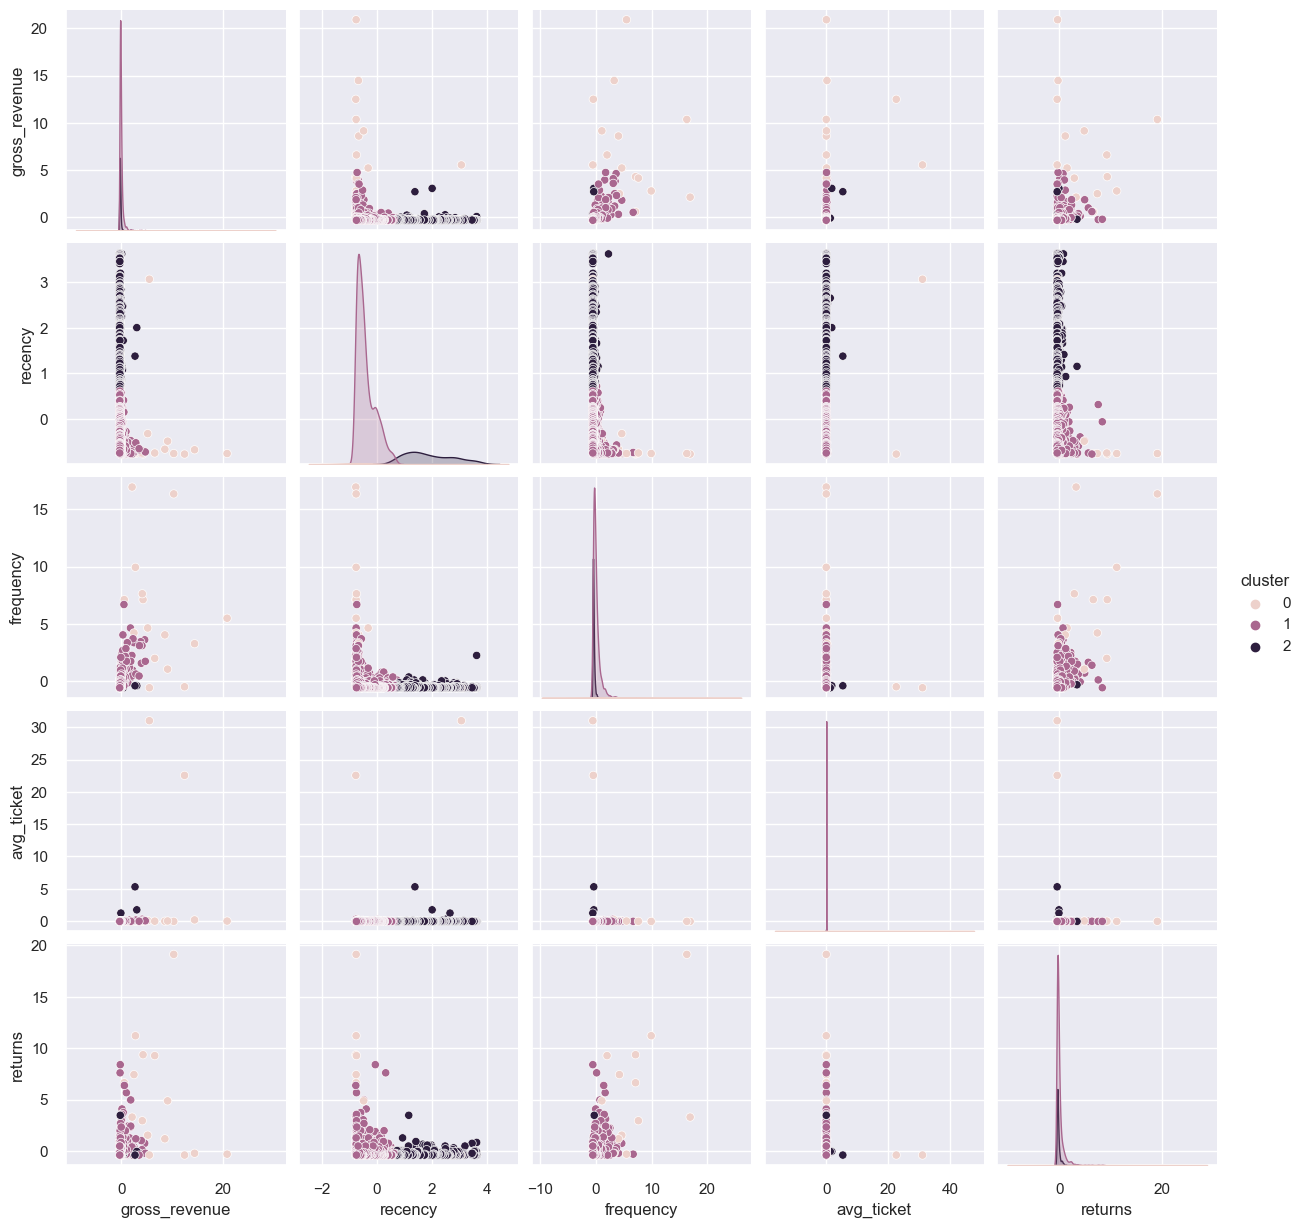

In [163]:
df_viz = df7.drop(columns='customer_id')
sns.pairplot(df_viz, hue='cluster');

### 10.3 *UMAP*

Ferramenta para nos dar ideia de como está organizado o cluster em alta dimensionalidade.

In [164]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform (X)

In [165]:
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

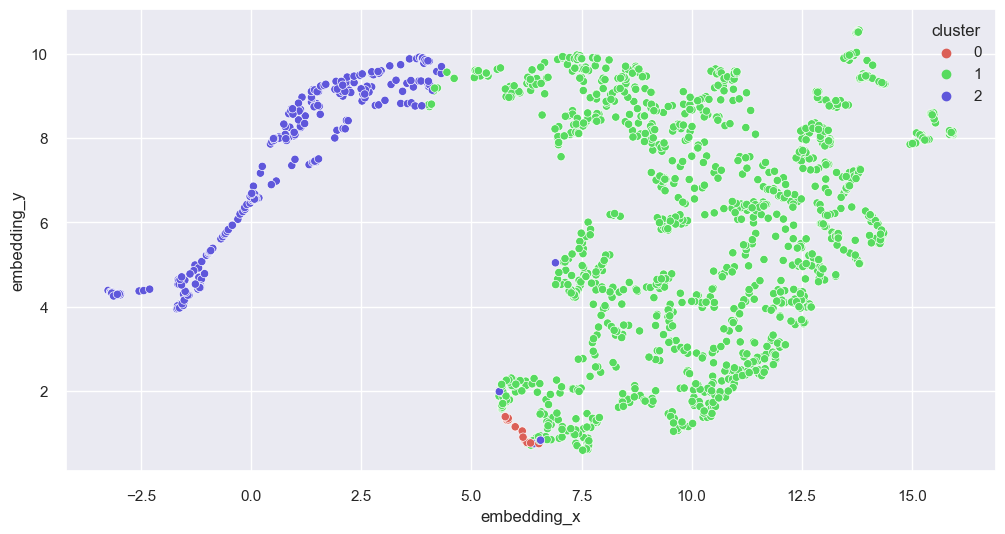

In [166]:
sns.scatterplot(x='embedding_x', y='embedding_y', 
                hue='cluster',
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                data=df_viz);

Se os pontos de mesmas cores estão próximos uns dos outros, isso significa que em alta dimensionalidade, os pontos estão dentro do mesmo cluster.

### 10.4 *Cluster Profile*

In [177]:
# Número de clientes por cluster
df_cluster = df7[['customer_id', 'cluster']].groupby('cluster').count().reset_index()

# Porcentagem em relação ao total de clientes
df_cluster['percentage'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

In [178]:
# Média de GrossRevenue por cluster
df_avg_revenue = df7[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_revenue, how='inner', on='cluster')

In [179]:
# Média de RecencyDays por cluster
df_avg_recency = df7[['recency', 'cluster']].groupby('cluster').mean().round().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency, how='inner', on='cluster')

In [180]:
# Média de Frequency por cluster
df_avg_frequency = df7[['frequency', 'cluster']].groupby('cluster').mean().round().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_frequency, how='inner', on='cluster')

In [181]:
# Ticket médio por cluster
df_ticket = df7[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

In [182]:
# Média de retornos por cluster
df_return = df7[['returns', 'cluster']].groupby('cluster').mean().round().reset_index()
df_cluster = pd.merge(df_cluster, df_return, how='inner', on='cluster')

In [183]:
df_cluster

,cluster,customer_id,percentage,gross_revenue,recency,frequency,avg_ticket,returns
0,0,15,1.00,100515.90,28.00,77.00,8994.35,63.00
1,1,1224,81.22,3486.19,30.00,8.00,28.64,5.00
2,2,268,17.78,1195.91,226.00,2.00,113.50,3.00


#### Cluster 1
- 6 Clientes (0.14% da base total)
- 7 dias de recência média
- 89 compras em média
- Aproximadamente 182.000 em receita em média

#### Cluster 2
- 31 Clientes (0.71% da base total)
- 13 dias de recência média
- 13 compras em média
- Aproximadamente 40.000 em receita em média

#### Cluster 0 
- 4335 clientes (99.15% da base total)
- 92 dias de recência média
- 5 compras em média
- Aproximadamente 1.300 de receita em média

## 11. Modelo em Produção